In [1]:
import re
import nltk
import pandas as pd
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read():
    return pd.read_csv("dataset/Corona_NLP_train.csv"), \
           pd.read_csv("dataset/Corona_NLP_test.csv")

def remove_urls(text):
    url_remover = re.compile(r'https?://\S+|www\.\S+')
    return url_remover.sub(r'', text)   
    
def remove_html(text):
    html_remover=re.compile(r'<.*?>')
    return html_remover.sub(r'',text)

def remove_mentions(text):
    mention_remover=re.compile(r'@\w+')
    return mention_remover.sub(r'',text)

def remove_numbers(text):
    number_remover=re.compile(r'\d+')
    return number_remover.sub(r'',text)

def remove_hashtags(text):
    number_remover=re.compile(r'#\w+')
    return number_remover.sub(r'',text)

def remove_punctuation(text):
    punct_remover=re.compile(r'[^\w\s\d]+')
    return punct_remover.sub(r'',text)

def remove_excessive_whitespace(text):
    ws_remover=re.compile(r'\s+')
    return ws_remover.sub(r' ', str(text)).strip()

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))     
    return " ".join([word for word in text.split(" ") if word not in stop_words]) 
    
def lowering(text):
    return text.lower()

def clean(df):
    df = df.loc[:,["OriginalTweet", "Sentiment"]]
    scores = {
        'Neutral': 0,     
        'Extremely Negative':-1, 
        'Negative':-1,
        'Positive':1,
        'Extremely Positive':1
    }
    df["score"] = df.Sentiment.apply(lambda x: scores[x])    
    df["neutrality"] = df.score.apply(lambda x: 1 if x == 0 else 0) 
    df.drop("Sentiment", inplace=True, axis=1)
    df.rename({"OriginalTweet": "text"}, axis=1, inplace=True)    
    df["text"] = df.text.apply(lambda x: remove_urls(x))
    df["text"] = df.text.apply(lambda x: remove_mentions(x))
    df["text"] = df.text.apply(lambda x: remove_html(x))
    df["text"] = df.text.apply(lambda x: remove_numbers(x))
    df["text"] = df.text.apply(lambda x: remove_hashtags(x))
    df["text"] = df.text.apply(lambda x: remove_punctuation(x))
    df["text"] = df.text.apply(lambda x: remove_excessive_whitespace(x))
    df["text"] = df.text.apply(lambda x: remove_stopwords(x))
    df["text"] = df.text.apply(lambda x: lowering(x))    
    return df

def cleaning():
    train, test = read()
    train = clean(train)
    test = clean(test)    
    return train, test    

def trainning(df_train):
    # Este é o algoritmo utilizado para vetorizar os textos dos tweets
    # Precisa ser o mesmo tanto no df de treino quanto no df de teste
    fitter = TfidfVectorizer(
        sublinear_tf=True, 
        min_df=5, 
        stop_words='english'
    ).fit(df_train.text)
    X_train = fitter.transform(df_train.text)
    y_train = df_train.neutrality
    model = LinearSVC()
    model.fit(X_train, y_train)
    
    df2_train = df_train[df_train.neutrality == 0]
    fitter2 = TfidfVectorizer(
        sublinear_tf=True, 
        min_df=5, 
        stop_words='english'
    ).fit(df2_train.text)
    
    X_train = fitter2.transform(df2_train.text)
    y_train = df2_train.score
    model2 = LinearSVC()
    model2.fit(X_train, y_train)
    return model, model2, fitter, fitter2

def testing(models, fitters, df_test):
    X_test = fitters[0].transform(df_test.text)
    y_test = df_test.neutrality
    y_pred = models[0].predict(X_test)
    print('CLASSIFICATION METRICS - NEUTRALITY\n')
    print(metrics.classification_report(
        y_test, 
        y_pred,
        target_names=['Not neutral','Neutral']
    ))
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                xticklabels=['Not neutral','Neutral'], 
                yticklabels=['Not neutral','Neutral']
                )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("CONFUSION MATRIX - NEUTRALITY - LinearSVC\n", size=16);
    
    df2_test = df_test[y_pred == 0]
    X_test = fitters[1].transform(df2_test.text)
    y_test = df2_test.score
    y_pred = models[1].predict(X_test)
    print('CLASSIFICATION METRICS NEUTRALITY\n')
    print(metrics.classification_report(
        y_test, 
        y_pred,
        # target_names=['Negative','Positive']
    ))
    
    #%%
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                # xticklabels=['Negative','Positive'], 
                # yticklabels=['Negative','Positive']
                )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

def main():
    df_train, df_test = cleaning()
    model, model2, tfidf_fitter, tfidf_fitter2 = trainning(df_train)
    testing([model, model2], [tfidf_fitter, tfidf_fitter2], df_test)

CLASSIFICATION METRICS - NEUTRALITY

              precision    recall  f1-score   support

 Not neutral       0.93      0.95      0.94      3179
     Neutral       0.71      0.61      0.66       619

    accuracy                           0.90      3798
   macro avg       0.82      0.78      0.80      3798
weighted avg       0.89      0.90      0.89      3798

CLASSIFICATION METRICS NEUTRALITY

              precision    recall  f1-score   support

          -1       0.80      0.85      0.83      1539
           0       0.00      0.00      0.00       241
           1       0.80      0.88      0.83      1483

    accuracy                           0.80      3263
   macro avg       0.53      0.58      0.55      3263
weighted avg       0.74      0.80      0.77      3263



c:\users\hc\.virtualenvs\sentihiv-1mniukwm\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


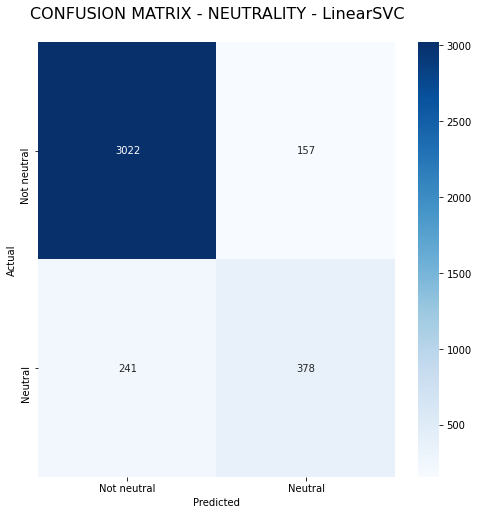

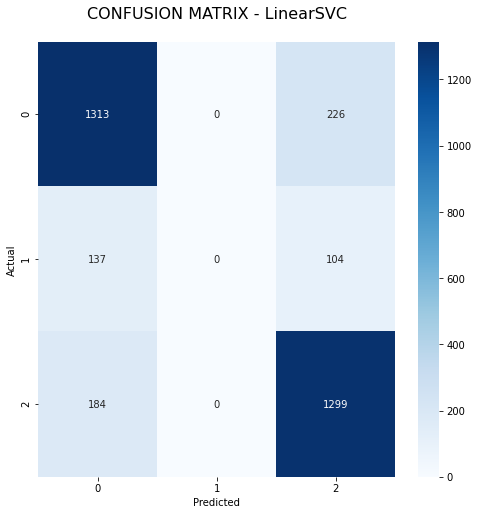

In [3]:
main()
